## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

In [1]:
#location of the data 
data_location =  'generated-data-api'
!ls $data_location

#reading the text data 
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)


captions.txt images
There are 324 image to captions


,image,caption
0,image_1.png,A A lion rampant
1,image_2.png,A A lion passt
2,image_3.png,A A lion passt guard
3,image_4.png,A A lion's head
4,image_5.png,A B lion rampant
5,image_6.png,A B lion passt
6,image_7.png,A B lion passt guard


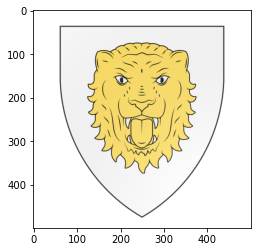

Caption: image_12.png
Caption: image_13.png
Caption: image_14.png
Caption: image_15.png
Caption: image_16.png


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

image_path = data_location + '/images/'+ df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:", df.iloc[i,0])


In [3]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image


In [4]:
#using spacy for the better text tokenization 
spacy_eng = spacy.blank("en")
# nlp = spacy.load("en_core_web_sm")

#example
text = "A lion rampant"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

# lion and rampant work together 

['a', 'lion', 'rampant']

In [5]:
class Vocabulary:
    def __init__(self,freq_threshold):
        
        # setting the pre-reserved tokens int to string tokens
        # index to string 
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
#         self.itos = {0:"<PAD>"}
        
        # <PAD>: padding, not part of the sequence represents a token which is the default token
        # <UNK>: unlclear, does not exist in our vocabulary 
        # <SOS>: start of sentence
        # <EOS>: end of sentence
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    


In [6]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)



v.build_vocab([ 'lion rampant', 'lion passt', 'lion passt guard', "lion's head",
               'cross', 'cross moline', 'cross patonce',
               'eagle', 'eagle doubleheaded',
              'A', 'B', 'O', 'S', 'G', 'E', 'V'])

print(v.stoi)
print(v.numericalize("A lion rampant"))

# Example: “<SOS> A lion rampant <EOS> <PAD> <PAD> <PAD>”

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, "'s": 8, 'head': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'a': 15, 'b': 16, 'o': 17, 's': 18, 'g': 19, 'e': 20, 'v': 21}
[15, 4, 5]


In [7]:
class CoADataset(Dataset):
 
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)


In [8]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [9]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


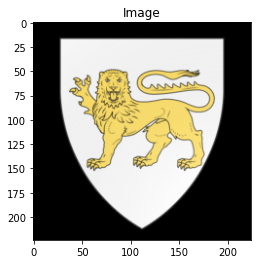

Token: tensor([ 1,  4, 12,  5,  6,  8,  2])
Sentence:
['<SOS>', 'a', 'o', 'lion', 'passt', 'guard', '<EOS>']


In [10]:
#testing the dataset class
dataset =  CoADataset(
    root_dir = data_location+"/images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)


img, caps = dataset[10]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [11]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
class DataLoader:

    def __iter__(self):
-        with ThreadPoolExecutor(max_workers=self.num_workers) as e:
-            for batch in e.map(self.get_batch, iter(self.batch_sampler)):
-                yield get_tensor(batch, self.pin_memory)
+        for batch in map(self.get_batch, iter(self.batch_sampler)):
+            yield get_tensor(batch, self.pin_memory)


In [15]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 0 # when put to 1, an error happens: DataLoader worker (pid(s) 7203) exited unexpectedly - kernel crushes

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)


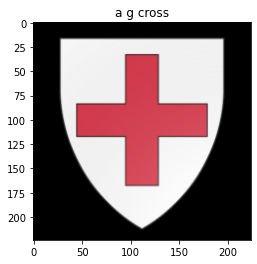

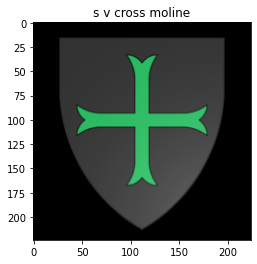

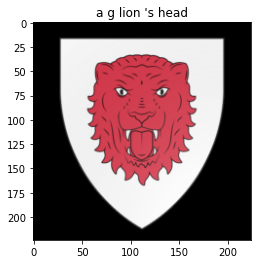

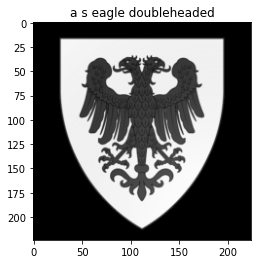

In [19]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()
